In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.utils import to_categorical
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout
from keras.models import model_from_json
import pickle

# Open csv & add header

In [5]:
#Open csv & add header
data = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', engine = 'python', header = None)
data.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

# It looks like there are only 0 and 4 values, no neutral values

In [6]:
set(data.target)

{0, 4}

# #Replace 4's by 1's in order to use a Sigmoid

In [7]:
data.target = (data.target).replace(4,1)

In [8]:
set(data.target)

{0, 1}

# Split data into train & test

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.text, data.target, test_size=0.10, random_state=48)

# Prepare sentences

In [10]:
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
print('prepearing train and test...')
# Train
for s in X_train:
  training_sentences.append(s)
for l in y_train:  
  training_labels.append(l)
#Test
for s in X_test:
  testing_sentences.append(s)
for l in y_test:  
  testing_labels.append(l)
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

prepearing train and test...


# Tokenize & process data

In [11]:
vocab_size = 30000
embedding_dim = 200
max_length = 120
trunc_type = 'post'
oov_tok =  '<OOV>'

In [12]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token= oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

# Define model

In [23]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

with tpu_strategy.scope():
    model = tf.keras.Sequential([
                                 tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
                                 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
                                 tf.keras.layers.Dense(128, activation='relu'),
                                 tf.keras.layers.Dropout((0.2)),
                                 tf.keras.layers.Dense(64, activation='relu'),
                                 tf.keras.layers.Dense(1, activation= 'sigmoid')
    ])

    model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
        name='Adam'),
                  metrics=['accuracy'])

# Fit model with 5 epochs, in order to see the plot's evolution

In [14]:
num_epochs = 5
history = model.fit(
    padded,
    training_labels,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels),
    batch_size = 16 * tpu_strategy.num_replicas_in_sync
)

Epoch 1/5
11250/11250 [==============================] - 225s 20ms/step - accuracy: 0.8176 - loss: 0.3997 - val_accuracy: 0.8321 - val_loss: 0.3734
Epoch 2/5
11250/11250 [==============================] - 219s 19ms/step - accuracy: 0.8465 - loss: 0.3471 - val_accuracy: 0.8367 - val_loss: 0.3672
Epoch 3/5
11250/11250 [==============================] - 228s 20ms/step - accuracy: 0.8651 - loss: 0.3106 - val_accuracy: 0.8349 - val_loss: 0.3761
Epoch 4/5
11250/11250 [==============================] - 222s 20ms/step - accuracy: 0.8841 - loss: 0.2721 - val_accuracy: 0.8313 - val_loss: 0.3925
Epoch 5/5
11250/11250 [==============================] - 228s 20ms/step - accuracy: 0.9020 - loss: 0.2336 - val_accuracy: 0.8258 - val_loss: 0.4408


# Plotting

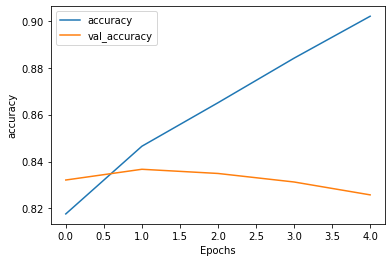

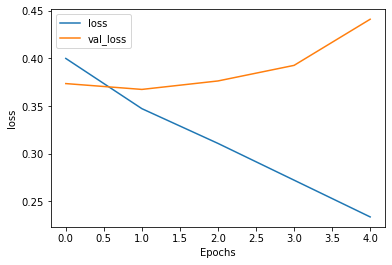

In [15]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [16]:
preds = model.predict(testing_padded)
print(classification_report(testing_labels, preds.round()))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83     80185
           1       0.83      0.83      0.83     79815

    accuracy                           0.83    160000
   macro avg       0.83      0.83      0.83    160000
weighted avg       0.83      0.83      0.83    160000



# Analysis after training:
### Looking at the results, one could notice that this model achieves it's best result at the second epoch. From the third epoch on wards, the model starts to overfit the training data, so it would be useless to train the model with more than 2 epochs.

# Taking in count the analysis results, now I restart the model and train the model with only 2 epochs

In [24]:
num_epochs = 2
history = model.fit(
    padded,
    training_labels,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels),
    batch_size = 16 * tpu_strategy.num_replicas_in_sync
)

Epoch 1/2
11250/11250 [==============================] - 226s 20ms/step - accuracy: 0.8177 - loss: 0.3997 - val_accuracy: 0.8324 - val_loss: 0.3752
Epoch 2/2
11250/11250 [==============================] - 221s 20ms/step - accuracy: 0.8464 - loss: 0.3469 - val_accuracy: 0.8368 - val_loss: 0.3659


# Plot the 2 epochs training

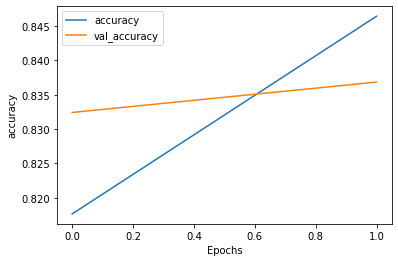

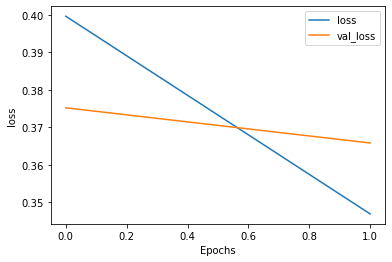

In [25]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Predict & show report

In [26]:
preds = model.predict(testing_padded)
print(classification_report(testing_labels, preds.round()))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     80185
           1       0.84      0.84      0.84     79815

    accuracy                           0.84    160000
   macro avg       0.84      0.84      0.84    160000
weighted avg       0.84      0.84      0.84    160000



## As we can see, there is a noticeable difference between both results. With 5 epochs, the model achieved an accuracy score of %82.58, while the 2 epoch model managed to get %83.68. Almost 1% more with less epochs, thus less training time.

# Save the 2 epoch model

In [27]:
filepath = 'model.json'
print('saving model...')
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

outfile = open('tokenizer.pkl','wb')
pickle.dump(tokenizer,outfile)
outfile.close()
print('Tokenizer saved!')
print('model saved!')

saving model...
Saved model to disk
Tokenizer saved!
model saved!


# plot of the roc curve for the model

### Now, we shall define the threshold value for our test

In [28]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(testing_labels, preds, pos_label=None)
thresholds

array([1.9999405e+00, 9.9994051e-01, 9.9984598e-01, ..., 5.2896142e-04,
       4.3803453e-04, 3.2070279e-04], dtype=float32)

In [30]:
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax
fpr, tpr, thresholds = roc_curve(testing_labels, preds)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.494858, G-Mean=0.837


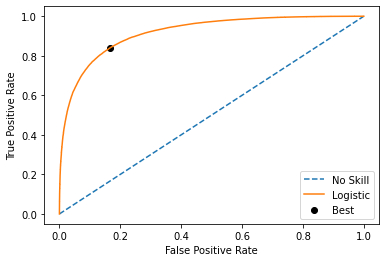

In [31]:
from matplotlib import pyplot
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

# Testing results with naive bayes

## This code is a modification of the version you can find at [Paolo Ripamonti's notebook](https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis)

In [ ]:
NEUTRAL='neutral'
NEGATIVE='negative'
POSITIVE='positive'
SENTIMENT_THRESHOLD = thresholds[ix]
trunc_type = 'post'

In [ ]:
import time
def decode_sentiment(score):
    return NEGATIVE if score <= SENTIMENT_THRESHOLD else POSITIVE

In [ ]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(
        tokenizer.texts_to_sequences([text]),
        maxlen=max_length,
        truncating=trunc_type)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

# Now, we can test our model. For instance, I will try to recognize the sentiment of 10 sentences

In [ ]:
res = predict(list("I suck at Mortal Kombat"))

print(res)

In [ ]:
res = predict(list("Your code is without doubt the worst code I've ever seen"))

print(res)

In [ ]:
res = predict(list("I love this song!"))
print(res)

In [ ]:
res = predict(list("I love cats"))
print(res)

In [ ]:
res = predict(list("I feel lucky today"))
print(res)

In [ ]:
res = predict(list("I hate storms"))
print(res)

In [ ]:
res = predict(list("this is a terrible moment"))
print(res)

In [ ]:
res = predict(list("I've failed my German exam"))
print(res)

In [ ]:
res = predict(list("The code looks clean"))
print(res)

In [ ]:
res = predict(list("you won't get that degree"))
print(res)

## The model managed to get 7 out 10 sentences correctly. As we can see, it is not a perfect model, but it's still good. If we look at the 10 predictions, it is clear that the model is mostly failing at predicting negative sentences.

# Possible improvements:
* Playing with the vocabulary size or the embedding dimension could lead to better (or worst) results
* Combining the use of threshold and the G-mean in order to add the possibility of neutral results
* Changing the loss function (see Huber loss) or tuning optimizer values
* The use of Transfer Learning techniques could improve the accuracy
